In [40]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [41]:
def get_data(ticker: str, interval: str = '1d', lookback_days: int = 756) -> pd.DataFrame:
    """
    Loads historical market data using yfinance.
    ticker (str): Stock or ETF symbol (e.g., 'SPY')
    interval (str): Data interval ('1d', '1h', '1m', etc.)
    lookback_days (int): Number of trading days to retrieve (capped at 7 if interval is one minute)

    Returns: pd.DataFrame: DataFrame downloaded from yfinance
    """
    if interval in ['1d', '1h']:
        period = str(lookback_days)+"d"
    elif interval == '1m':
        period = "7d"  
    else:
        raise ValueError("Unsupported interval for free data")
    df = yf.download(ticker, period=period, interval=interval, progress=False)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df = df.dropna()
    df = df.rename(columns=str.lower)
    df.index.name = 'datetime'

    return df

In [42]:
df = get_data("SPY","1d",756)
#SMA
df['30_day_SMA'] = df['close'].rolling(30).mean().shift(1)
#Moving V
df['30_day_volat'] = df['close'].rolling(30).std().shift(1)

df = df.drop(df.index[:30]).copy()
df['days_sequence'] = range(1, len(df) + 1)

df['y_next_ret'] = df['close'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)
df = df.dropna(subset=['y_next_ret']).copy()

df.info()
print(df.head())
print(df.describe())

/var/folders/sk/xk40gf9n2q3bhq2s90436ctr0000gn/T/ipykernel_7803/4255546963.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 725 entries, 2022-10-03 to 2025-08-22
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          725 non-null    float64
 1   high           725 non-null    float64
 2   low            725 non-null    float64
 3   open           725 non-null    float64
 4   volume         725 non-null    int64  
 5   30_day_SMA     725 non-null    float64
 6   30_day_volat   725 non-null    float64
 7   days_sequence  725 non-null    int64  
 8   y_next_ret     725 non-null    float64
 9   y_up           725 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 62.3 KB
                 close        high         low        open     volume  \
datetime                                                                
2022-10-03  352.810608  354.677588  345.689153  347.488761   89756500   
2022-10-04  363.742981  363.771851  352.772090  358.382632  103602800   
2022-

In [43]:
cut=int(len(df)*0.8)
train, test = df.iloc[:cut], df.iloc[cut:]
features=['30_day_SMA','30_day_volat']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']


In [44]:
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))
print('RMSE:', rmse)

RMSE: 25.150298691963872


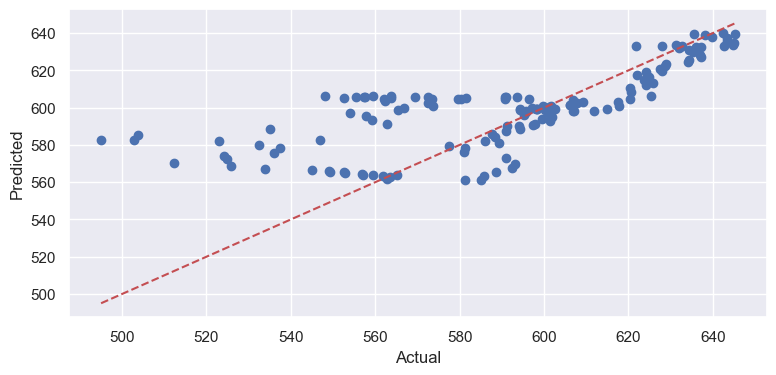

In [45]:
plt.scatter(y_te_reg, pred)
plt.plot([y_te_reg.min(), y_te_reg.max()], [y_te_reg.min(), y_te_reg.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
